In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = pd.read_csv("diabetes.csv")

#### Which data types are the columns?

In [3]:
f.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

#### Do we have any null values? 

In [4]:
f.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### So, no nulls and all values are numerical - no need for imputation or manipulations on our features..

### Let's take a look on the features' distributions:

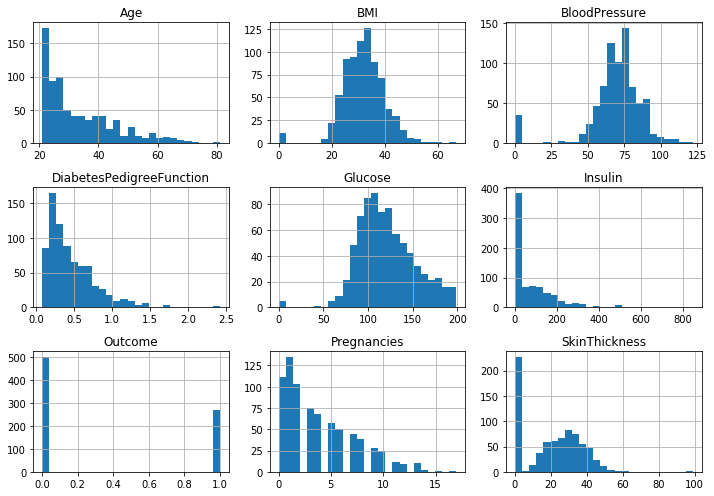

In [5]:
f.hist(bins = 25,figsize = (10,7))
plt.tight_layout()
plt.show()

## Generate different pre-processed tables with:
* Removed outliers
* Removed zero values (specific type of outlier)
* Zero values are replaced/imputed by mean/median

### Removed outliers: 
* Define outliers as data points below/above -4/+4 std (Quite rough definition for an outlier)
* Then, outlier can be either removed or imputed - let's simply remove them

In [6]:
def drop_outliers(ds):
    if len(ds.unique())>5: # Don't apply the condition on variables with less than 5 values
        high_out = ds.mean() + ds.std()*4
        low_out = ds.mean() - ds.std()*4
        return ds[(ds<high_out) & (ds > low_out)]
    else:
        return ds

In [7]:
# Apply the function above on each column. Outliers are returned as null values - 
# so each line containing null will be dropped.

f_dropped_outliers = f.apply(drop_outliers).dropna()


### Zero values replaced by mean value: 

In [8]:
f_impute_zeros = f.copy()

In [9]:
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_impute_zeros.loc[f_impute_zeros[col]==0,col] = f_impute_zeros.loc[f[col]>0,col].mean()
    #f = f[f[col]>0]

### Zero values are dropped (~33% data loss):

In [10]:
f_dropped_zeros = f_dropped_outliers.copy()
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_dropped_zeros = f_dropped_zeros[f_dropped_zeros[col]>0]

## Test diferent models on the different tables:

In [11]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

import xgboost as xgb

##### Define prediction function

In [12]:
def predict(model,f,train_index,test_index):
    model.fit(f.loc[train_index].drop('Outcome',1),f.loc[train_index,'Outcome'])
    auc = roc_auc_score(f.loc[test_index,'Outcome'],[i[1] for i in model.predict_proba(f.loc[test_index].drop('Outcome',1))])
    return model.score(f.loc[test_index].drop('Outcome',1),f.loc[test_index,'Outcome']),auc
    

### Tune trees models hyperparameters:

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

#### Random forests : Find N best hyperparameters for accuracy ad AUC:

In [14]:
file = f_impute_zeros
dict_best_auc = {}
dict_best_scr = {}
for ml in range(8,15,2):
    for md in range (2,14,2):
        model = ensemble.RandomForestClassifier(min_samples_leaf=ml,max_depth=md)
        dict_best_auc[(ml,md)] = np.mean([predict(model,file,train_index,test_index)[1] for train_index,test_index in kf.split(file)])
        dict_best_scr[(ml,md)] = np.mean([predict(model,file,train_index,test_index)[0] for train_index,test_index in kf.split(file)])

dd = pd.Series(dict_best_auc).sort_values()[-3:].append(pd.Series(dict_best_scr).sort_values()[-3:])
dd = dd.reset_index()
dd.columns = ['min_leaf','max_depth','result']
dd   

,min_leaf,max_depth,result
0,10,4,0.824546
1,14,4,0.828169
2,14,12,0.828323
3,12,6,0.768229
4,10,10,0.772135
5,10,8,0.776042


#### XGBoost : Find N best hyperparameters for accuracy ad AUC:

In [15]:
file = f_impute_zeros

dict_best_auc = {}
dict_best_scr = {}
for ml in range(8,15,2):
    for md in range (2,10,2): 
        model = xgb.XGBClassifier(min_child_weight=ml,max_depth=md)
        dict_best_scr[(ml,md)] = np.mean([predict(model,file,train_index,test_index)[0] for train_index,test_index in kf.split(file)])
        dict_best_auc[(ml,md)] = np.mean([predict(model,file,train_index,test_index)[1] for train_index,test_index in kf.split(file)])
dd = pd.Series(dict_best_auc).sort_values()[-3:].append(pd.Series(dict_best_scr).sort_values()[-3:])
dd = dd.reset_index()
dd.columns = ['min_leaf','max_depth','result']
dd  

,min_leaf,max_depth,result
0,14,2,0.832255
1,12,2,0.832511
2,10,2,0.833156
3,8,4,0.764323
4,12,6,0.765625
5,12,8,0.765625


### Compare models applied on the differently-processed tables:

In [16]:
f_train,f_test = train_test_split(f,test_size = 0.3)
f_drop_zero_train,f_drop_zero_test = train_test_split(f_dropped_zeros,test_size = 0.3)
f_impute_zero_train,f_impute_zero_test = train_test_split(f_impute_zeros,test_size = 0.3)

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

def predict(model,f,train_index,test_index):
    model.fit(f.loc[train_index].drop('Outcome',1),f.loc[train_index,'Outcome'])
    auc = roc_auc_score(f.loc[test_index,'Outcome'],[i[1] for i in model.predict_proba(f.loc[test_index].drop('Outcome',1))])
    return model.score(f.loc[test_index].drop('Outcome',1),f.loc[test_index,'Outcome']),auc

ll = []
l = ['All','Imputed','Dropped']
for i,file in enumerate([f.sample(len(f)).reset_index(drop=True),f_impute_zeros.sample(len(f_impute_zeros)).reset_index(drop=True),f_dropped_zeros.sample(len(f_dropped_zeros)).reset_index(drop=True)]):
    #print (l[i],'\n')
    for model in [ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8),
                 xgb.XGBClassifier(min_child_weight=10,max_depth=3),linear_model.LogisticRegression(),naive_bayes.GaussianNB()]:
        ll.append( [str(model).split('(')[0]] +[l[i]]+ pd.DataFrame([predict(model,file,train_index,test_index) for train_index,test_index in kf.split(file)]).mean().values.tolist())
    
df= pd.DataFrame(ll).pivot_table(columns = 0,index = 1,values = [2,3])
df

2                             3            \
1                            All   Dropped   Imputed       All   Dropped   
0                                                                          
GaussianNB              0.757812  0.762627  0.752604  0.815339  0.835525   
LogisticRegression      0.776042  0.768411  0.751302  0.825527  0.831073   
RandomForestClassifier  0.763021  0.774150  0.755208  0.824835  0.834164   
XGBClassifier           0.763021  0.779919  0.748698  0.823189  0.840549   

                                  
1                        Imputed  
0                                 
GaussianNB              0.814724  
LogisticRegression      0.824257  
RandomForestClassifier  0.833409  
XGBClassifier           0.826454

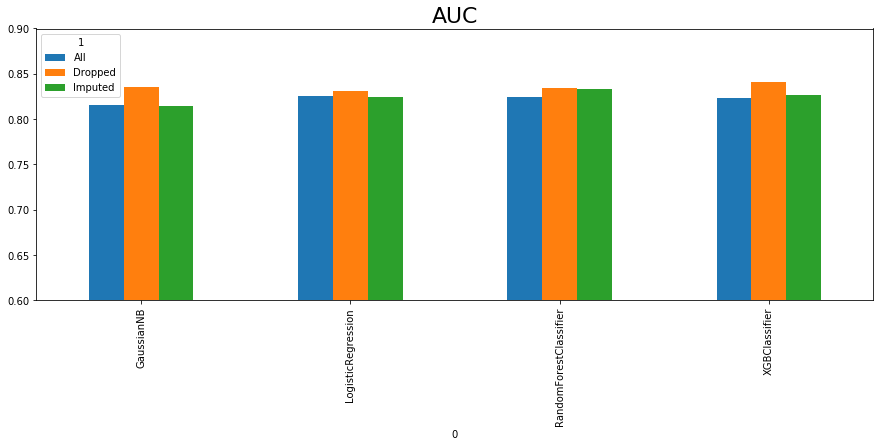

In [18]:
df[3].plot(kind='bar',figsize=(15,5))
plt.ylim((0.6,0.9))
plt.title('AUC',fontsize=22)
plt.show()

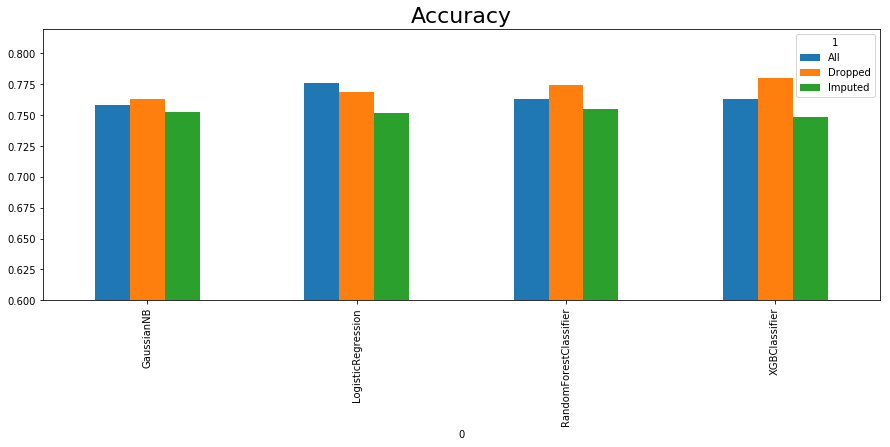

In [19]:
df[2].plot(kind='bar',figsize=(15,5))
plt.ylim((0.6,0.82))
plt.title('Accuracy',fontsize=22)
plt.show()

### Mid-conclusion : Dropping 0 values is somewhat better than imputing them - Probably since simple replacement to mean/median is not enough.


### Deal with un-balanced data

In [20]:
from imblearn import over_sampling , under_sampling

In [21]:
sm = over_sampling.SMOTE()
X_res, y_res = sm.fit_sample(f_train.drop('Outcome',1),f_train['Outcome'])

In [22]:
model = linear_model.LogisticRegression()
model.fit(X_res,y_res)
auc = roc_auc_score(f_test['Outcome'], [i[1] for i in model.predict_proba(f_test.drop('Outcome',1))])
print (model.score(f_test.drop('Outcome',1),f_test['Outcome']) , auc)

0.753246753247 0.814735099338


## Open the random forest "black box"

### 1. Segmentation with Random forests - very shallow trees , 200 estimators - ** Select the dropped Vs other cleansed files**

In [23]:
train = f_drop_zero_train
test = f_drop_zero_test
#train = f_impute_zero_train
#test = f_impute_zero_test

model = ensemble.RandomForestClassifier(min_samples_leaf=10,max_depth=2,n_estimators=200)
model.fit(train.drop('Outcome',1),train['Outcome'])
scr = model.score(test.drop('Outcome',1),test['Outcome'])
auc_score = roc_auc_score(test['Outcome'],[i[1] for i in model.predict_proba(test.drop('Outcome',1))])
avg_precision = average_precision_score(test['Outcome'],[i[1] for i in model.predict_proba(test.drop('Outcome',1))])

print (scr,auc_score,avg_precision)

0.75641025641 0.878127812781 0.819901091678


In [24]:
feature_names = pd.Series(train.columns)
feature_names[-2] = None

all_splits = pd.DataFrame(index=feature_names)


for i,tt in enumerate(model.estimators_):
    pp = pd.DataFrame(index = ['feature','split_point'], data=[tt.tree_.feature,tt.tree_.threshold]).T
    pp['feature_name'] = pp['feature'].map(feature_names)
    pp['split_point'] = pp['split_point'].apply(lambda x: float("%.1f" %x))
    all_splits[i] = pp.groupby('feature_name').apply(lambda x: x.split_point.values)

aa  =all_splits.T.apply(lambda x: list(np.hstack(x.values)))    
df_splits = pd.DataFrame(aa).T.apply(lambda x: pd.Series(x[0])).apply(lambda x: x.value_counts().to_dict())

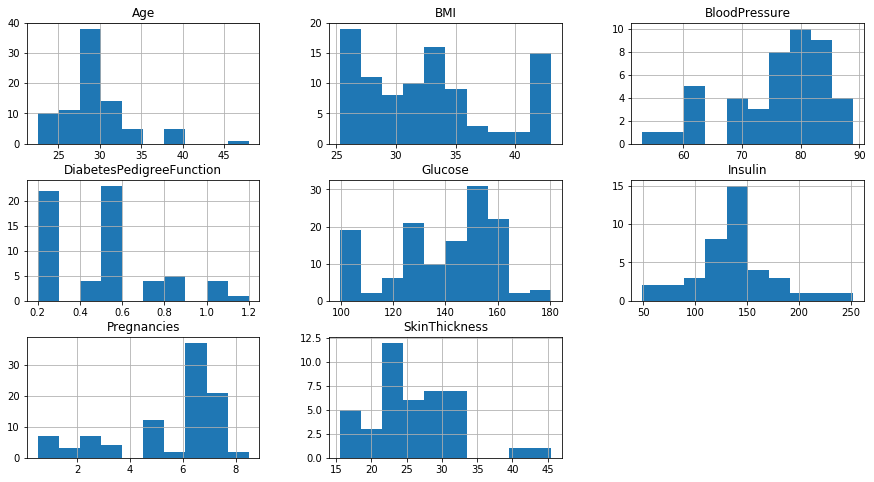

In [25]:
pd.DataFrame(aa).T.drop([None,'Outcome'],1).apply(lambda x: pd.Series(x[0])).hist(bins = 10,figsize = (15,8))
plt.show()

In [26]:
def get_splits(x):
    x = pd.Series(x)
    his = np.histogram(x.dropna())
    h1 = pd.Series(index=his[0],data=his[1][1:].tolist()).reset_index().reset_index().sort_values('index',ascending = False)
    
    # Take highest 2 bars and determine their distance and height ratio, If they far and similar height - show both:
    diff_peak = (h1.iloc[:2,1].diff().abs().tolist()[1] / h1.iloc[1,1]) < 0.33
    dist_peak = h1.iloc[:2,0].diff().abs().tolist()[1] > 1
    
    if (diff_peak and dist_peak):
        return (h1[0].iloc[:2].values)
    else:
        return ([h1[0].iloc[0].tolist()])

In [27]:
aa1 = aa.apply(get_splits)
print(aa1)

def calc_group(x):
    return pd.concat([x < i for i in aa1.loc[x.name]],1).sum(1)

t_segments = test.drop('Outcome',1).apply(calc_group)
t_segments['Outcome'] = test['Outcome']

print ('\n\nSegmented : ', t_segments.groupby(t_segments.drop('Outcome',1).columns.tolist())['Outcome'].std().mean(),
       '\nAll : ', t_segments['Outcome'].std())

Pregnancies                          [6.9]
Glucose                            [156.2]
BloodPressure                       [81.8]
SkinThickness                       [24.5]
Insulin                           [150.75]
BMI                         [27.07, 34.15]
DiabetesPedigreeFunction        [0.6, 0.3]
Age                                [30.15]
Outcome                              [0.1]
NaN                                  [0.1]
dtype: object


Segmented :  0.2824837233081395 
All :  0.4793071232988253


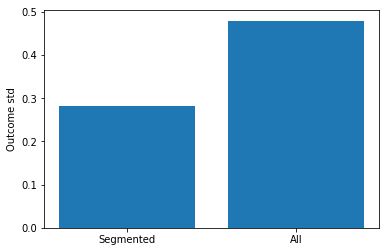

In [28]:
plt.bar([0,1],[ t_segments.groupby(t_segments.drop('Outcome',1).columns.tolist())['Outcome'].std().mean(),t_segments['Outcome'].std()])
plt.xticks([0,1],['Segmented','All'])
plt.ylabel('Outcome std')
plt.show()

### Conclusions about segmentation:
* The average std of the outcome (diabete class) within the segmented groups is considerably lower than the std of the whole dataset
* Domain knowledge - different 'Risk groups' could be determined. For example BMI > 29.8 

### 2. Find important interactions

In [29]:
list_relates = []
for i in range(len(model.estimators_)):
    estimator = model.estimators_[i]
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left # get all left children 
    children_right = estimator.tree_.children_right # get all right children
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # The root: (node id , parent depth)
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If not a leaf - add
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
            
            
    for i in range(n_nodes):
        if is_leaves[i]:
            None #print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else :
            if(feature_names[feature[children_left[i]]] ):
                list_relates.append((feature_names[feature[i]] ,feature_names[feature[children_left[i]]] ))
            if(feature_names[feature[children_right[i]]] ):
                list_relates.append((feature_names[feature[i]] ,feature_names[feature[children_right[i]]] ))
    

#### Coupled interactions, ordered by their frequency:

In [30]:
pd.Series(list_relates).append(pd.Series(list_relates).apply(lambda x: x[::-1])).value_counts()[::]

(BMI, Glucose)                               33
(Glucose, BMI)                               33
(Glucose, Pregnancies)                       32
(Pregnancies, Glucose)                       32
(Glucose, Age)                               32
(Age, Glucose)                               32
(BMI, Pregnancies)                           29
(Pregnancies, BMI)                           29
(Age, BMI)                                   24
(Glucose, DiabetesPedigreeFunction)          24
(BMI, Age)                                   24
(DiabetesPedigreeFunction, Glucose)          24
(Age, Pregnancies)                           22
(Glucose, Glucose)                           22
(Pregnancies, Age)                           22
(DiabetesPedigreeFunction, Pregnancies)      18
(Pregnancies, DiabetesPedigreeFunction)      18
(Glucose, SkinThickness)                     17
(SkinThickness, Glucose)                     17
(Age, Insulin)                               14
(Insulin, Age)                          

#### Seems that BMI and Glucose level interact very often, as well as BMI and Glucose level. These insights can be used in different directions:
* Domain knowledge - for example, Define groups in High risk for diabetes by simple combinations of,say, high BMI and low Glucose levels, etc.
* New features - derived from the interactions - can be generated and added to the linear model, in order to improve it's performance (as described in the lines below) : 

#### 4 main interactions - GlucoseXAge, GlucoseXBMI,AgeXBMI , GlucoseXPregnancies - were generated as new features and added to the linear model:

In [31]:
def generate_interacting_feature(n1,n2,ttrain,ttest):
    ttest[n1+'X'+n2] = ttest[n1+'_s'].astype(str) + ttest[n2+'_s'].astype(str)
    ttrain[n1+'X'+n2] = ttrain[n1+'_s'].astype(str) + ttrain[n2+'_s'].astype(str)
    ttrain = pd.concat([ttrain,pd.get_dummies(ttrain[n1+'X'+n2],prefix=n1+'X'+n2)],1).drop(n1+'X'+n2,1)
    ttest = pd.concat([ttest,pd.get_dummies(ttest[n1+'X'+n2],prefix=n1+'X'+n2)],1).drop(n1+'X'+n2,1)
    return ttrain,ttest

In [32]:
ttrain = train.copy()
ttest = test.copy()
for col in ['Glucose', 'Age', 'BMI','Pregnancies']:
    ttrain[col+'_s'] = calc_group(ttrain[col])
    ttest[col+'_s'] = calc_group(ttest[col])

In [33]:
ttrain,ttest = generate_interacting_feature('Glucose','Age',ttrain,ttest)
ttrain,ttest = generate_interacting_feature('Glucose','BMI',ttrain,ttest)
ttrain,ttest = generate_interacting_feature('BMI','Age',ttrain,ttest)
ttrain,ttest = generate_interacting_feature('Glucose','Pregnancies',ttrain,ttest)

In [34]:
ttest = ttest.drop(['Glucose_s', 'BMI_s', 'Age_s','Pregnancies_s'],1)
ttrain = ttrain.drop(['Glucose_s', 'BMI_s', 'Age_s','Pregnancies_s'],1)

In [35]:
lr = linear_model.LogisticRegression()
lr.fit(ttrain.drop('Outcome',1),ttrain['Outcome'])
print(roc_auc_score(ttest['Outcome'], [i[1] for i in lr.predict_proba(ttest.drop('Outcome',1))]))
confusion_matrix(ttest['Outcome'], lr.predict(ttest.drop('Outcome',1)))

0.854545454545


array([[85, 16],
       [17, 38]], dtype=int64)

In [36]:
lr = linear_model.LogisticRegression()
lr.fit(train.drop('Outcome',1),train['Outcome'])
print(roc_auc_score(test['Outcome'], [i[1] for i in lr.predict_proba(test.drop('Outcome',1))]))
confusion_matrix(test['Outcome'], lr.predict(test.drop('Outcome',1)))

0.877767776778


array([[94,  7],
       [29, 26]], dtype=int64)

#### While perfomance for logit model with features interactions are quite similar to the model without interactions,However, keep in mind: 
* They still preform better FOR HIGHER RATE OF TRUE POSITIVES
* Improvement is significant in case of Random forest perfoms considerably better than linear model.

## Conclusions:
#### Besides a straightforward prediction, Random forests can provide very valuable domain insights:
* Best split points for continuous variables -> which ranges are most likely to axplain the outcome?
    * Derive new segments that can be used for further inspections.
    * Find new categories / sub-groups in each continuous variable.
* Interactions -> Which variables have higher impact when combined: 
    * Very useful for further research poprposes : find new hidden connections that may better explain the outome.
    * Improve linear (/logistic) regression models - vary useful when simple model is required.
